In [1]:
!pip install prophet

  Using cached cmdstanpy-1.2.2-py3-none-any.whl (94 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


You should consider upgrading via the 'C:\Users\Mitra\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data = pd.read_csv('POPTHM.csv', sep = ',', encoding = 'utf-8')

In [4]:
data.head()

,DATE,POPTHM
0,1959-01-01,178504
1,1960-01-01,182225.0
2,1961-01-01,185129
3,1962-01-01,187905
4,1963-01-01,190570


In [5]:
data.tail()

,DATE,POPTHM
61,2020-01-01,332062.0
62,2021-01-01,332891.0
63,2022-01-01,334326.0
64,2023-01-01,336070.0
65,2024-01-01,.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    66 non-null     object
 1   POPTHM  66 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [7]:
data.describe()

,DATE,POPTHM
count,66,66
unique,66,66
top,1959-01-01,178504
freq,1,1


In [8]:
data.nunique()

DATE      66
POPTHM    66
dtype: int64

In [9]:
# Replace non-numeric values with NaN
data['POPTHM'] = pd.to_numeric(data['POPTHM'], errors='coerce')

# Drop rows with missing values (NaN)
data.dropna(inplace=True)


In [10]:
data.tail()

,DATE,POPTHM
60,2019-01-01,331345.0
61,2020-01-01,332062.0
62,2021-01-01,332891.0
63,2022-01-01,334326.0
64,2023-01-01,336070.0


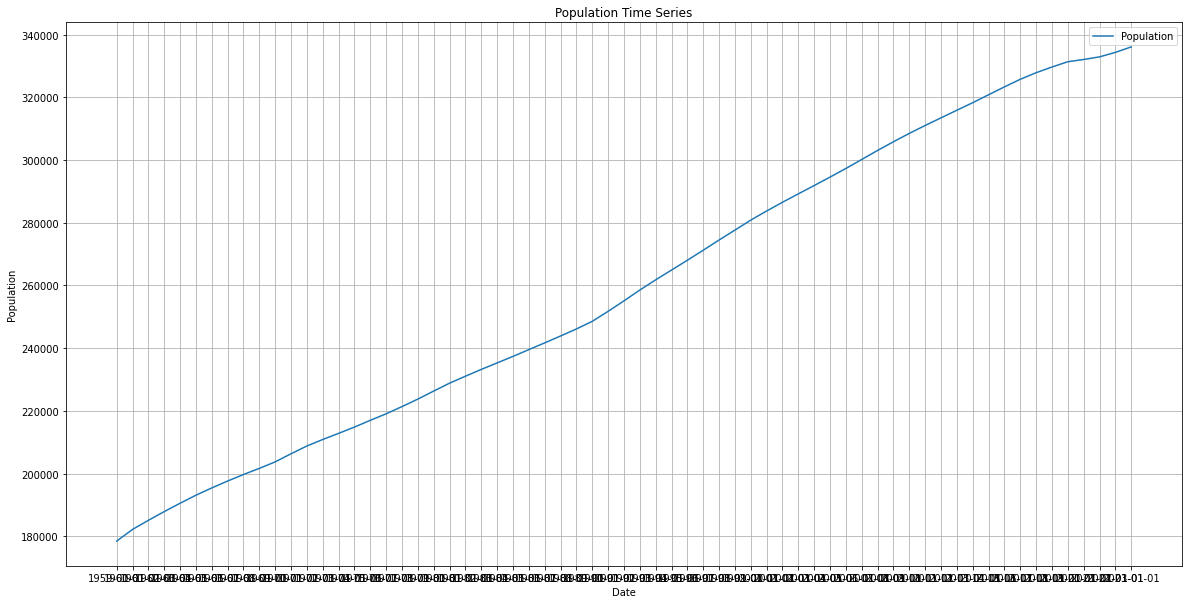

In [11]:
# Visualize the population time series
plt.figure(figsize=(20, 10))
plt.plot(data['DATE'], data['POPTHM'], label='Population')
plt.title('Population Time Series')
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Decompose the time series into trend, seasonality, and residual components
decomposition = seasonal_decompose(data['POPTHM'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

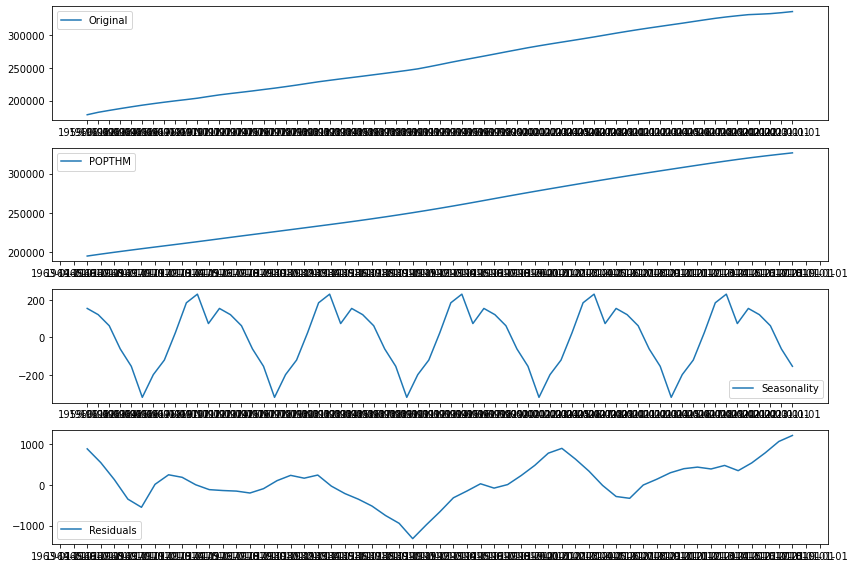

In [13]:

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['DATE'], data['POPTHM'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(data['DATE'], trend, label='POPTHM')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(data['DATE'], seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(data['DATE'], residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


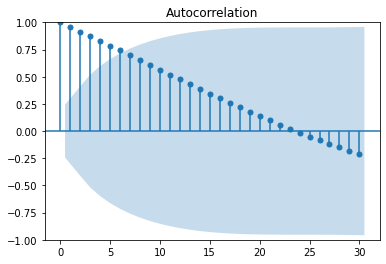

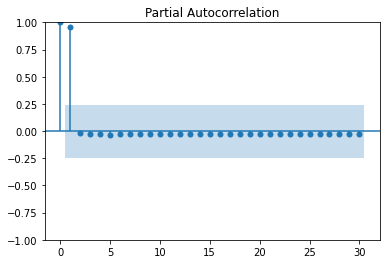

In [14]:
# Plot autocorrelation and partial autocorrelation functions
plot_acf(data['POPTHM'], lags=30)
plot_pacf(data['POPTHM'], lags=30)
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

# Assuming your time series data is in a DataFrame named `data` with a column 'POPTHM'
# Replace 'POPTHM' with the actual column name containing your time series data

# Perform ADF test
result = adfuller(data['POPTHM'])

# Extract and print results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.6322571519815448
p-value: 0.863525396109518
Critical Values:
   1%: -3.540522678829176
   5%: -2.9094272025108254
   10%: -2.5923136524453696


In [16]:
# Compute the first-order difference
data['POPTHM_diff'] = data['POPTHM'].diff()

# Drop the first row since differencing results in a NaN value for the first observation
data.dropna(inplace=True)

# Print the differenced data
print(data.head())

         DATE    POPTHM  POPTHM_diff
1  1960-01-01  182225.0       3721.0
2  1961-01-01  185129.0       2904.0
3  1962-01-01  187905.0       2776.0
4  1963-01-01  190570.0       2665.0
5  1964-01-01  193131.0       2561.0


In [17]:
# Perform ADF test on the differenced series
result_diff = adfuller(data['POPTHM_diff'])

# Extract and print results
print('ADF Statistic (Differenced Series):', result_diff[0])
print('p-value (Differenced Series):', result_diff[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic (Differenced Series): -2.2345975367497704
p-value (Differenced Series): 0.19392896177384822
Critical Values (Differenced Series):
   1%: -3.540522678829176
   5%: -2.9094272025108254
   10%: -2.5923136524453696


In [18]:
# Compute the second-order difference
data['POPTHM_diff_2'] = data['POPTHM_diff'].diff()

# Drop the first two rows since differencing results in NaN values for the first two observations
data.dropna(inplace=True)

# Print the second-order differenced data
print(data.head())

         DATE    POPTHM  POPTHM_diff  POPTHM_diff_2
2  1961-01-01  185129.0       2904.0         -817.0
3  1962-01-01  187905.0       2776.0         -128.0
4  1963-01-01  190570.0       2665.0         -111.0
5  1964-01-01  193131.0       2561.0         -104.0
6  1965-01-01  195456.0       2325.0         -236.0


In [19]:
# Perform ADF test on the differenced series
result_diff = adfuller(data['POPTHM_diff_2'])

# Extract and print results
print('ADF Statistic (Differenced Series):', result_diff[0])
print('p-value (Differenced Series):', result_diff[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic (Differenced Series): -6.3186019332523475
p-value (Differenced Series): 3.10598769023475e-08
Critical Values (Differenced Series):
   1%: -3.540522678829176
   5%: -2.9094272025108254
   10%: -2.5923136524453696


In [49]:
# Initialize Prophet model
model = Prophet()

In [50]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [21]:
# Create a new DataFrame with 'ds' and 'y' columns for Prophet using the training set
prophet_train_data = pd.DataFrame({
    'ds': train['DATE'],  # Assuming the index contains the dates after differencing
    'y': train['POPTHM_diff_2']  # Assuming 'POPTHM_diff_2' is the second-order differenced series
})

# Fit the Prophet model on the training data
model.fit(prophet_train_data)

15:22:40 - cmdstanpy - INFO - Chain [1] start processing
15:22:41 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Specify the number of periods to forecast
future_periods = len(test)

#future_periods = model.make_future_dataframe(periods=365)

In [23]:
# Make future predictions
future = model.make_future_dataframe(periods=future_periods)

# Forecast future values
forecast = model.predict(future)

# Print forecasted values for the test set
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test)))

           ds         yhat   yhat_lower   yhat_upper
50 2010-01-02   -36.106774  -323.825941   216.709590
51 2010-01-03  -227.167223  -495.252227    45.103333
52 2010-01-04  -526.068629  -796.990803  -240.559201
53 2010-01-05  -924.513462 -1201.605719  -647.443678
54 2010-01-06 -1411.402422 -1670.921322 -1144.531812
55 2010-01-07 -1973.131979 -2245.232247 -1700.467257
56 2010-01-08 -2593.959018 -2853.078754 -2323.989457
57 2010-01-09 -3256.422686 -3525.463966 -2964.222274
58 2010-01-10 -3941.811981 -4214.473754 -3658.823456
59 2010-01-11 -4630.666401 -4901.615094 -4332.415268
60 2010-01-12 -5303.296103 -5571.042654 -5024.496058
61 2010-01-13 -5940.307482 -6198.745060 -5667.091958
62 2010-01-14 -6523.120004 -6811.397242 -6243.111910


In [27]:
test

,DATE,POPTHM,POPTHM_diff,POPTHM_diff_2
52,2011-01-01,313454.0,2434.0,-91.0
53,2012-01-01,315877.0,2423.0,-11.0
54,2013-01-01,318276.0,2399.0,-24.0
55,2014-01-01,320815.0,2539.0,140.0
56,2015-01-01,323318.0,2503.0,-36.0
57,2016-01-01,325742.0,2424.0,-79.0
58,2017-01-01,327848.0,2106.0,-318.0
59,2018-01-01,329659.0,1811.0,-295.0
60,2019-01-01,331345.0,1686.0,-125.0
61,2020-01-01,332062.0,717.0,-969.0


In [51]:
# Extract actual values from the testing set
actual_values = test['POPTHM_diff_2'].values  # 'POPTHM_diff_2' is the second-order differenced series in the test set

# Extract forecasted values from the forecast DataFrame
forecast_values = forecast['yhat'][-len(test):].values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100

# Print performance metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 2315.597750613669
Mean Squared Error (MSE): 9011253.185307626
Root Mean Squared Error (RMSE): 3001.8749449814904
Mean Absolute Percentage Error (MAPE): 6844.744348689811


In [34]:
# Generate future dates for predictions

future_periods = model.make_future_dataframe(periods=12 * 5, freq='M')
#future_periods = len(test_data)

#future_periods = model.make_future_dataframe(periods=365)

future = model.make_future_dataframe(periods=365)

In [45]:
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
410,2010-12-28,-874.835973,-1142.893847,-592.768085,-213.736035,-213.736036,-213.736033
411,2010-12-29,-487.105824,-766.671562,-218.496239,-213.729015,-213.729016,-213.729014
412,2010-12-30,-199.499522,-477.406039,60.351852,-213.721996,-213.721996,-213.721994
413,2010-12-31,-20.136044,-285.259332,257.677364,-213.714976,-213.714977,-213.714974
414,2011-01-01,45.897940,-217.270956,316.256237,-213.707956,-213.707957,-213.707954


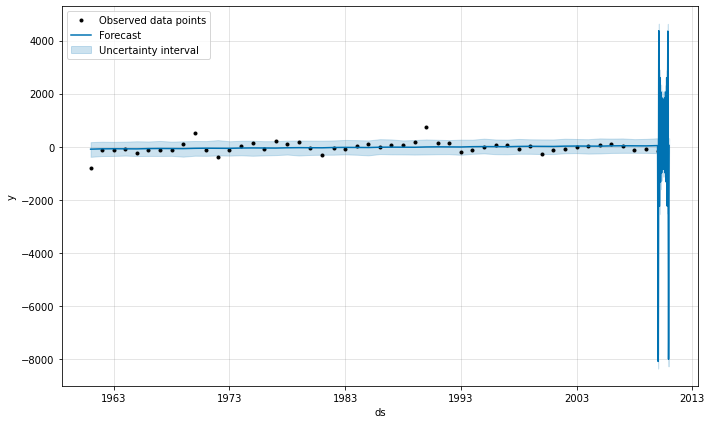

In [46]:
fig1 = model.plot(forecast, include_legend=True)

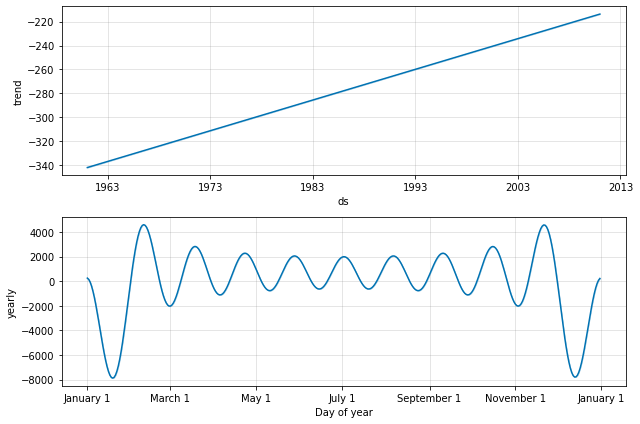

In [47]:
fig2 = model.plot_components(forecast)

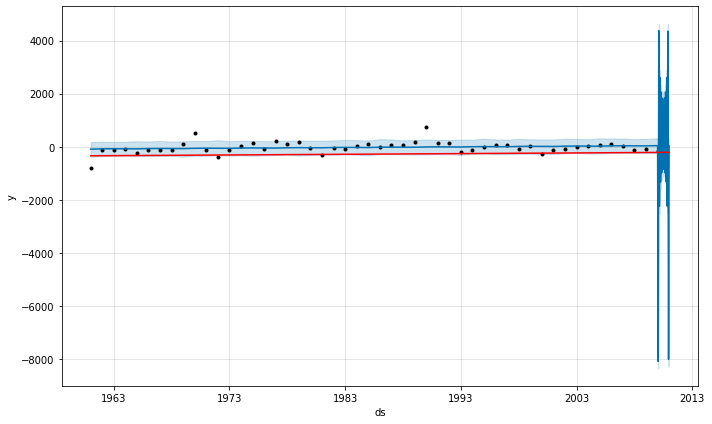

In [48]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),
                             model, forecast)